TODO list:
* Add test loss (Davit) - **Done**
* Refactor forward and backward (Igor) - **Done**
* Make get_params to return dictionary (Davit) - 
* Check parameter init with DL course (Davit) - **Done**
* Think about output shape. Transpose output to N * 2 (Igor) - **Done**
* Add constructor for sequential (Igor) - **Done**
* Maybe add batchsize sgd (Davit) - **Done** by Igor in process of testing output shape
* Add more sophisticated sgd method (Davit) - **I am lazy**
* Maybe add more layer types (Dropout if we overfit) (Oganes) - 
* Maybe add more layer types (Binary Cross Entropy) (Davit) - **Done**
* Add comments (Davit) - **Done**
* Start report (Igor) - 
* Make module names lowercase (Igor) - **Done**
* See why model with 100 hidden neurons is not converging (Noone) - **Solved**

In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import math
from IPython import display
matplotlib.style.use('ggplot')
torch.set_grad_enabled(False)

from utilities import generate_disc_set, compute_nb_errors, get_batches, accuracy
from loss import Loss, MSE, CrossEntropy
from module import DenseLayer, ReLU, Sequential, Tanh, Sigmoid, SoftMax

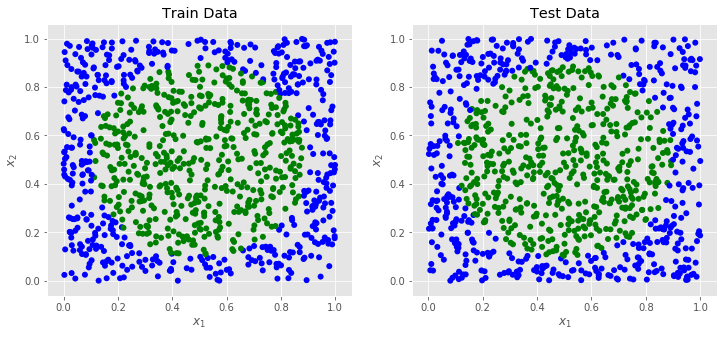

In [2]:
total_size = 2000
train_size = 1000
test_size = 1000

data, target = generate_disc_set(total_size,random_state=1)

train_data, train_target = data[:train_size], target[:train_size]
test_data, test_target = data[test_size:], target[test_size:]

colours = ['blue','green','red']

def colour_labels(labels):
    return list(map(lambda x: colours[x], labels))


plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.scatter(train_data[:, 0], train_data[:, 1], c=colour_labels(train_target.argmax(1)), edgecolors='none')
plt.title('Train Data')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')


# plt.figure(figsize=(6,6))
plt.subplot(1, 2, 2)
plt.scatter(test_data[:, 0], test_data[:, 1], c=colour_labels(test_target.argmax(1)), edgecolors='none')
plt.title('Test Data')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')

plt.show()

In [3]:
net_loss = MSE()

In [4]:
def create_model(n_hidden=25):
    net = Sequential(DenseLayer(2, n_hidden),
                     ReLU(), 
                     DenseLayer(n_hidden, n_hidden), 
                     ReLU(),
                     DenseLayer(n_hidden, n_hidden),
                     ReLU(),
                     DenseLayer(n_hidden, 2))
    return net

In [5]:
n_hidden = 25
net = create_model(n_hidden)
print(net)

Linear 2 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 25
ReLU
Linear 25 -> 2



In [6]:
def sgd(x, dx, config):
    for cur_layer_x, cur_layer_dx in zip(x, dx):
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):

            cur_old_grad = config['learning_rate'] * cur_dx

            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)

            cur_x.add_(-cur_old_grad)

In [7]:
def train_model(model, model_loss, train_data, train_target, lr=0.005, batch_size=1, plot_loss=False, n_epoch=50):
    optimizer_config = {'learning_rate': lr}
    train_loss_history = []
    test_loss_history = []
    
    for i in range(n_epoch):
        loss = 0
        
        k = 0
        for x_batch, y_batch in get_batches(train_data, train_target, batch_size):
            model.zero_grad_params()

            # Forward
            pred = model.forward(x_batch)
            loss += model_loss.forward(pred, y_batch)
            
            # Backward
            lg = model_loss.backward(pred, y_batch)
            model.backward(lg)
            
            # Update weights
            sgd(net.get_params(), 
                net.get_grad_params(), 
                optimizer_config)  
            k+=1
        
        train_loss_history.append(loss/k)
        
        test_pred = model.forward(test_data)
        test_loss = model_loss.forward(test_pred, test_target)
        test_loss_history.append(test_loss)
        
        if plot_loss:
            # Visualize
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))
        
            plt.title("Train and Test Loss")
            plt.xlabel("#Epochs")
            plt.ylabel("loss")
            plt.plot(train_loss_history, 'b')
            plt.plot(test_loss_history, 'r')
            plt.legend(['train loss', 'test loss'])
            plt.show()
    
            print('Current train loss: {:.4f}'.format(loss.item()/k))

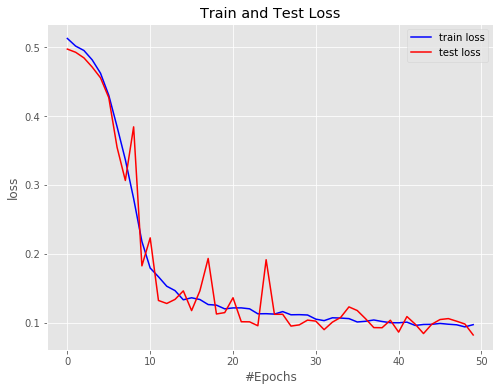

Current train loss: 0.0971


In [8]:
train_model(net, net_loss, train_data, train_target, plot_loss=True, n_epoch=50)

In [9]:
train_res = net.forward(train_data)
errors_train = compute_nb_errors(train_res, train_target)
print(f"Number of errors on the train set: {errors_train}")
train_res = train_res.argmax(1)
train_res[train_res != train_target.argmax(1)] = 2

Number of errors on the train set: 23


In [10]:
test_res = net.forward(test_data)
errors_test = compute_nb_errors(test_res, test_target)
print(f"Number of errors on the test set: {errors_test}")
test_res = test_res.argmax(1)
test_res[test_res != test_target.argmax(1)] = 2

Number of errors on the test set: 24


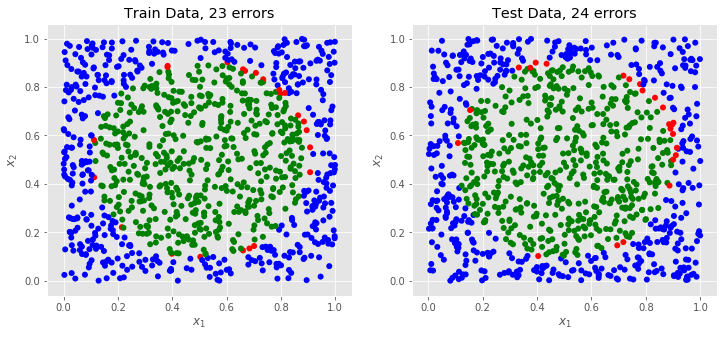

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_data[:, 0], train_data[:, 1], c=colour_labels(train_res), edgecolors='none')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Train Data, {errors_train} errors')

plt.subplot(1, 2, 2)
plt.scatter(test_data[:, 0], test_data[:, 1], c=colour_labels(test_res), edgecolors='none')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Test Data, {errors_test} errors')

plt.show()

In [ ]:
# test_acc = []

# for _ in range(50):
#     test_data, test_target = generate_disc_set(test_size)
#     pred = net.forward(test_data)
#     test_acc.append(accuracy(pred,test_target))
    
# print(sum(test_acc) / len(test_acc) )

In [ ]:
# Trying with cross-entropy loss
net_loss = CrossEntropy()

n_hidden = 25
net = Sequential(DenseLayer(2, n_hidden),
                 ReLU(), 
                 DenseLayer(n_hidden, n_hidden), 
                 ReLU(), 
                 DenseLayer(n_hidden, n_hidden),
                 ReLU(), 
                 DenseLayer(n_hidden, 2), 
                 SoftMax())

print(net)

In [ ]:
train_model(net, net_loss, train_data, train_target, plot_loss=True, n_epoch=50)

In [ ]:
train_res = net.forward(train_data)
errors_train = compute_nb_errors(train_res, train_target)
print(f"Number of errors on the train set: {errors_train}")
train_res = train_res.argmax(1)
train_res[train_res != train_target.argmax(1)] = 2

In [ ]:
test_res = net.forward(test_data)
errors_test = compute_nb_errors(test_res, test_target)
print(f"Number of errors on the test set: {errors_test}")
test_res = test_res.argmax(1)
test_res[test_res != test_target.argmax(1)] = 2

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_data[:, 0], train_data[:, 1], c=colour_labels(train_res), edgecolors='none')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Train Data, {errors_train} errors')

plt.subplot(1, 2, 2)
plt.scatter(test_data[:, 0], test_data[:, 1], c=colour_labels(test_res), edgecolors='none')
plt.xlabel(r'$x_{1}$')
plt.ylabel(r'$x_{2}$')
plt.title(f'Test Data, {errors_test} errors')

plt.show()

In [ ]:
# print('Train accuracy:',accuracy(net.forward(train_data),train_target) * 100)
# print('Test accuracy:',accuracy(net.forward(test_data),test_target) * 100)

### Plot decision boundaries

In [ ]:
import numpy as np
import matplotlib.patches as mpatches

In [ ]:
def visualize_decision_boundaries(model, N=100, title=None):
    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    xs, ys = np.meshgrid(xs, ys)
    xs, ys = xs.flatten(), ys.flatten()
    
    results = []
    for x, y in zip(xs, ys):
        results.append(model.forward(torch.tensor([x, y]).unsqueeze(0)).argmax().item())
    
    colors = {0:'red',1:'blue'}
    result_colors = [colors[res] for res in results]
    labels = ['Class 1','Class 2']

    plt.figure(figsize=(5, 5))
    plt.scatter(xs, ys, c=result_colors)
    if title:
        plt.title(title + " model's decision boundaries")
    else:
        plt.title("Model's decision boundaries")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    
    recs = []
    for i in range(len(labels)):
         recs.append(mpatches.Rectangle((0,0), 1, 1, fc=list(colors.values())[i]))
    plt.legend(recs, labels, loc=4, ncol=3)

    plt.show()

In [ ]:
visualize_decision_boundaries(net)

Let's see the importance of number of hidden neurons

In [ ]:
test_different_hidden_sizes = True

In [ ]:
if test_different_hidden_sizes:
    for n_hidden in [5, 10, 25, 50, 100]:
        net = create_model(n_hidden)
        train_model(net, net_loss, train_data, train_target, n_epoch = 40)
        visualize_decision_boundaries(net, title=f"Model with {n_hidden} hidden neurons")

Our observations:
* Decision boundary's shape is becoming closer to circle with more hidden neurons. 
* There is no significant improvement after number of hidden neurons more than 25